# TÜBİTAK 2204-D Lise Öğrencileri İklim Değişikliği Araştırma Projeleri Yarışması 2022
# Kuraklık Tespitine Yapay Zeka ile Bakış: Konya Kapalı Havzası Kuraklık Tahmini
Çalışmamızın kodları bu sayfada mevcuttur.

Bu sayfada;

* Harita Genel Müdürlüğü İlçe Sınırları veri setinin incelenmesini,
* İlçe Sınırları veri setinden havzaya ait ilçe sınırlarının seçilmesini ve düzenlenmesini
* Birleştirilen görüntülerin ilçelere göre kırpılması ve kaydedilmesini göreceksiniz.

# Kütüphaneler
Python programlama dili ile yazılmaktadır.

earthpy ve rioxarray kütüphaneleri Kaggle'da yüklü olmadığı için ortamımıza yüklememiz gerekmektedir.

In [1]:
!pip install earthpy
!pip install rioxarray

     |████████████████████████████████| 1.4 MB 803 kB/s            
     |████████████████████████████████| 47 kB 474 kB/s            
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ | / - done
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54609 sha256=5c93c54318f21e0dcb3e5c72fbe5587d755b0123ee1b0bbe6010bb404719cf44
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from shapely.ops import polygonize
from shapely.geometry import Polygon, LineString, MultiLineString, MultiPolygon, mapping

import folium

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# İlçe Sınırları Veri Setinin İçeri Aktarılması

Bu veri seti Milli Savunma Bakanlığı Harita Genel Müdürlüğü resmi sayfasından ücretsiz bir şekilde alınmıştır. Bu veri seti herkese açıktır.

In [3]:
shp_list = []
for i in os.listdir("../input/2204-d-l-ve-l-e-veri-setini-d-zenleme/Ilce_Polygonlar"):
    if i.endswith(".shp"):
        shp_list.append(i)
shp_list

['Ilce_Aksu_Sinirlari_Polygon.shp',
 'Ilce_Beysehir_Sinirlari_Polygon.shp',
 'Ilce_Cumra_Sinirlari_Polygon.shp',
 'Ilce_Seydisehir_Sinirlari_Polygon.shp',
 'Ilce_Ilgin_Sinirlari_Polygon.shp',
 'Ilce_Altinekin_Sinirlari_Polygon.shp',
 'Ilce_Huyuk_Sinirlari_Polygon.shp',
 'Ilce_Ulukisla_Sinirlari_Polygon.shp',
 'Ilce_Sarayonu_Sinirlari_Polygon.shp',
 'Ilce_Sereflikochisar_Sinirlari_Polygon.shp',
 'Ilce_Kazimkarabekir_Sinirlari_Polygon.shp',
 'Ilce_Kulu_Sinirlari_Polygon.shp',
 'Ilce_Meram_Sinirlari_Polygon.shp',
 'Ilce_Yalihuyuk_Sinirlari_Polygon.shp',
 'Ilce_Ciftlik_Sinirlari_Polygon.shp',
 'Ilce_Erdemli_Sinirlari_Polygon.shp',
 'Ilce_Kadinhani_Sinirlari_Polygon.shp',
 'Ilce_Mut_Sinirlari_Polygon.shp',
 'Ilce_Nevsehir_Merkez_Sinirlari_Polygon.shp',
 'Ilce_Bala_Sinirlari_Polygon.shp',
 'Ilce_Derinkuyu_Sinirlari_Polygon.shp',
 'Ilce_Guneysinir_Sinirlari_Polygon.shp',
 'Ilce_Karaman_Sinirlari_Polygon.shp',
 'Ilce_Sariyahsi_Sinirlari_Polygon.shp',
 'Ilce_Camliyayla_Sinirlari_Polygon.shp',
 

In [4]:
ilce_shp_path = "../input/2204-d-l-ve-l-e-veri-setini-d-zenleme/Ilce_Sinirlari_Polygon.shp"
ilce_shp = gpd.read_file(ilce_shp_path)

In [5]:
il_shp_path = "../input/2204-d-l-ve-l-e-veri-setini-d-zenleme/Il_Sinirlari_Polygon.shp"
il_shp = gpd.read_file(il_shp_path)

Aynı ile ait birden fazla polygonlar var. Bunları teker teker GeoDataFrame yapabiliriz.

İl sınırlarına kırpmadan farklı olarak burada her bir ilçe için geodataframe oluşturmayacağız. Çünkü ilçelerimizin sayısı çok fazla. Kırpma işlemi esnasında geodataframe oluşturup kırpacağız.

# Uydu Görüntülerinin İlçe Sınırlarına Göre Kırpılması

Önceki sayfalarda birleştirdiğimiz görüntüleri kırpacağız.

In [6]:
nbalist = os.listdir("../input/2204-d-havza-ndvi-l89")
nbalist.sort()
nbalist

['Havza_2013_ndvi.tif',
 'Havza_2014_ndvi.tif',
 'Havza_2015_ndvi.tif',
 'Havza_2016_ndvi.tif',
 'Havza_2017_ndvi.tif',
 'Havza_2018_ndvi.tif',
 'Havza_2019_ndvi.tif',
 'Havza_2020_ndvi.tif',
 'Havza_2021_ndvi.tif',
 '__notebook__.ipynb',
 '__output__.json',
 '__results__.html',
 '__results___files',
 'custom.css']

In [7]:
nbalist = nbalist[:-5]
nbalist

['Havza_2013_ndvi.tif',
 'Havza_2014_ndvi.tif',
 'Havza_2015_ndvi.tif',
 'Havza_2016_ndvi.tif',
 'Havza_2017_ndvi.tif',
 'Havza_2018_ndvi.tif',
 'Havza_2019_ndvi.tif',
 'Havza_2020_ndvi.tif',
 'Havza_2021_ndvi.tif']

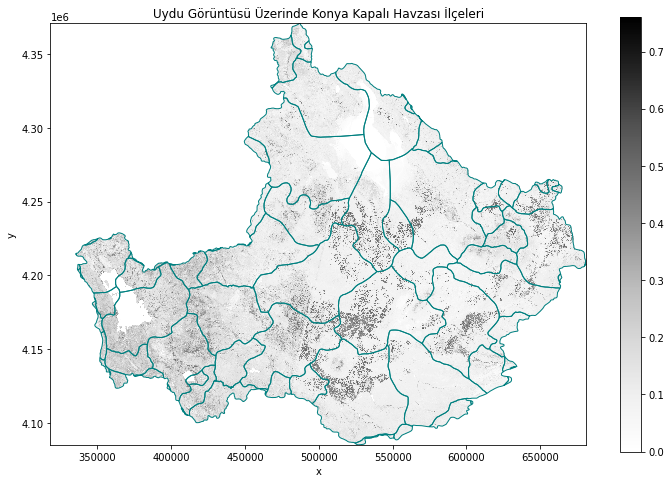

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
img_path = "../input/2204-d-havza-ndvi-l89/Havza_2014_ndvi.tif"
img_arr = rxr.open_rasterio(img_path, masked=True).squeeze()
img_arr.plot.imshow(cmap="Greys", ax=ax)

ilce_shp = ilce_shp.to_crs(crs = img_arr.rio.crs)
ilce_shp.plot(color="none", edgecolor="teal" ,ax = ax)
ax.set(title="Uydu Görüntüsü Üzerinde Konya Kapalı Havzası İlçeleri")
plt.show()

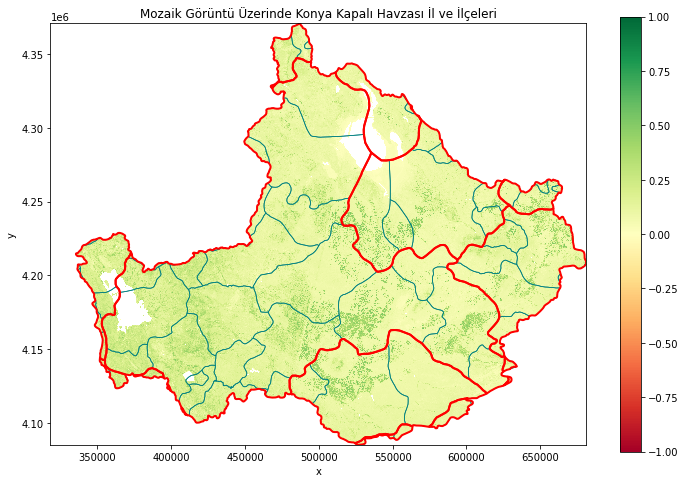

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
img_path = "../input/2204-d-havza-ndvi-l89/Havza_2014_ndvi.tif"
img_arr = rxr.open_rasterio(img_path, masked=True).squeeze()
img_arr.plot.imshow(cmap="RdYlGn", vmin=-1, vmax = 1, ax=ax)

ilce_shp = ilce_shp.to_crs(crs = img_arr.rio.crs)
il_shp = il_shp.to_crs(crs = img_arr.rio.crs)
ilce_shp.plot(color="none", edgecolor="teal", linewidth = 0.75, ax = ax)
il_shp.plot(color="none", edgecolor="red", linewidth = 2, ax = ax)
ax.set(title="Mozaik Görüntü Üzerinde Konya Kapalı Havzası İl ve İlçeleri")
plt.show()

In [10]:
for year in range(2013,2022):
    os.mkdir("./Year"+str(year))

In [11]:
def clippingilceler(bandlist):
    sayac = 0
    for uydu in bandlist:
        inpath = os.path.join("../input/2204-d-kkh-birle-tirme-lemi-1/", uydu)
        year = uydu[6:10]
        
        img_arr = rxr.open_rasterio(img_path, masked=True).squeeze()
        img_arr = img_arr.rio.reproject("EPSG:4326")
        
        for shp in shp_list:
            gdf = gpd.read_file("../input/2204-d-l-ve-l-e-veri-setini-d-zenleme/Ilce_Polygonlar/"+shp)
            clipped = img_arr.rio.clip(gdf.geometry.apply(mapping))
            ilce = list(enumerate(gdf.ilce))[0][1]
            outpath = os.path.join("./Year"+year, ilce+"_"+year+"_"+"ndvi.tif")
            clipped.rio.to_raster(outpath)
            
        print("****************** Yıl {} bitti *********************".format(sayac+2013))
        sayac+=1

In [12]:
clippingilceler(nbalist)

/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


****************** Yıl 2013 bitti *********************


/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


****************** Yıl 2014 bitti *********************


/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


****************** Yıl 2015 bitti *********************


/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


****************** Yıl 2016 bitti *********************


/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


****************** Yıl 2017 bitti *********************


/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


****************** Yıl 2018 bitti *********************


/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


****************** Yıl 2019 bitti *********************


/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


****************** Yıl 2020 bitti *********************


/opt/conda/lib/python3.7/site-packages/rioxarray/raster_writer.py:109: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  f"The nodata value ({original_nodata}) has been automatically "


****************** Yıl 2021 bitti *********************


Kırptığımız görüntüler nasıl gözüküyor, bakalım.

# **İLÇELERİN İSİMLERİ YANLIŞ ONLARI DÜZELT**

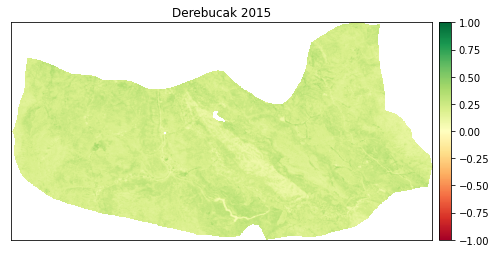

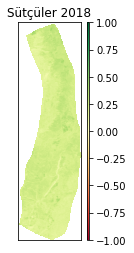

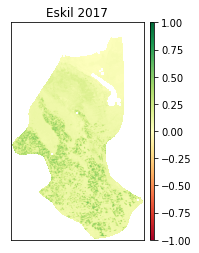

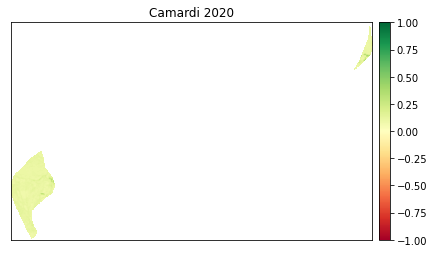

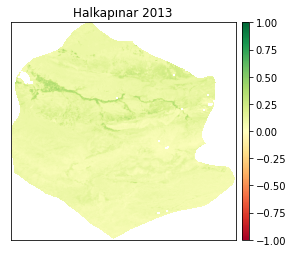

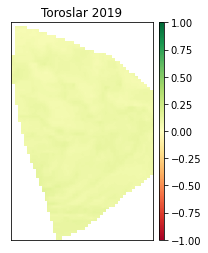

In [13]:
derebucakdene = rxr.open_rasterio("./Year2015/Derebucak_2015_ndvi.tif", masked = True).squeeze()
sutculerdene = rxr.open_rasterio("./Year2018/Sutculer_2018_ndvi.tif", masked = True).squeeze()
eskildene = rxr.open_rasterio("./Year2017/Eskil_2017_ndvi.tif", masked = True).squeeze()
camardidene = rxr.open_rasterio("./Year2020/Camardi_2020_ndvi.tif", masked = True).squeeze()
halkapinardene = rxr.open_rasterio("./Year2013/Halkapinar_2013_ndvi.tif", masked = True).squeeze()
toroslardene = rxr.open_rasterio("./Year2019/Toroslar_2019_ndvi.tif", masked = True).squeeze()
ep.plot_bands(derebucakdene, figsize = (8,4), vmin=-1, vmax = 1, cmap = "RdYlGn", title = "Derebucak 2015")
ep.plot_bands(sutculerdene, figsize = (8,4), vmin=-1, vmax = 1, cmap = "RdYlGn", title = "Sütçüler 2018")
ep.plot_bands(eskildene, figsize = (8,4), vmin=-1, vmax = 1, cmap = "RdYlGn", title = "Eskil 2017")
ep.plot_bands(camardidene, figsize = (8,4), vmin=-1, vmax = 1, cmap = "RdYlGn", title = "Camardi 2020")
ep.plot_bands(halkapinardene, figsize = (8,4), vmin=-1, vmax = 1, cmap = "RdYlGn", title = "Halkapınar 2013")
ep.plot_bands(toroslardene, figsize = (8,4), vmin=-1, vmax = 1, cmap = "RdYlGn", title = "Toroslar 2019")
plt.show()

In [14]:
np.mean(eskildene)

<xarray.DataArray ()>
array(0.13887282, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [15]:
np.mean(toroslardene)

<xarray.DataArray ()>
array(0.0868044, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0